## setup env

In [1]:
%load_ext Cython
%matplotlib inline

7.4.0


In [2]:
DEBUG=False

In [3]:
from gym_sokoban.envs import SokobanEnv
import matplotlib.pyplot as plt

## setup DataGenerator

In [4]:
%%cython
# --annotate
import marshal
import numpy as np
from gym_sokoban.envs.room_utils import room_topology_generation, box_displacement_score, ACTION_LOOKUP, reverse_move

class DataGenerator:
    def __init__(self):
        self.num_boxes = 0
        self.best_actions = []
    
    
    def resetEnv(self, env, num_boxes):
        self.num_boxes = num_boxes
        empty_room = room_topology_generation(dim=env.dim_room, num_steps=env.num_gen_steps)
        return self.place_boxes_and_player(empty_room)
        
    
    def place_boxes_and_player(self, room, second_player=False):
        # Get all available positions
        possible_positions = np.where(room == 1)
        num_possible_positions = possible_positions[0].shape[0]
        num_players = 2 if second_player else 1

        if num_possible_positions <= self.num_boxes + num_players:
            raise RuntimeError('Not enough free spots (#{}) to place {} player and {} boxes.'.format(
                num_possible_positions,
                num_players,
                self.num_boxes)
            )

        placed_player = False

        # place boxes
        for n in range(self.num_boxes):
            possible_positions = np.where(room == 1)
            num_possible_positions = possible_positions[0].shape[0]

            ind = np.random.randint(num_possible_positions)
            box_position = possible_positions[0][ind], possible_positions[1][ind]
            room[box_position] = 2

            # place player
            if not placed_player:
                for player_position in [
                    (box_position[0] + 1, box_position[1]), (box_position[0] - 1, box_position[1]),
                    (box_position[0], box_position[1] + 1), (box_position[0], box_position[1] - 1)
                ]:
                    if room[player_position] == 1:
                        room[player_position] = 5
                        placed_player = True
                        break

        return room
    
    def get_room_state(self, room):
        # Room structure represents the current state of the room including movable parts
        room_state = room.copy()
        room_state[room_state == 2] = 4
        return room_state
    
    def get_room_structure(self, room):
        # Room fixed represents all not movable parts of the room
        room_structure = np.copy(room)
        room_structure[room_structure == 5] = 1
        return room_structure

    def reverse_playing(self, room_state, room_structure, max_action_length, explored_states_max):
        """
        This function plays Sokoban reverse in a way, such that the player can move and pull boxes.
        It ensures a solvable level with all boxes not being placed on a box target.
        """

        # Box_Mapping is used to calculate the box displacement for every box
        box_mapping = {}
        box_locations = np.where(room_structure == 2)
        num_boxes = len(box_locations[0])
        for l in range(num_boxes):
            box = (box_locations[0][l], box_locations[1][l])
            box_mapping[box] = box

        # reset explored_states globally stores the best room state and score found during search
        self.explored_states = set()
        self.best_room_score = -1
        self.best_box_mapping = box_mapping
        self.depth_first_search(room_state, room_structure, box_mapping,
                                box_swaps=0, last_pull=(-1, -1), ttl=300, max_action_length=max_action_length, explored_states_max=explored_states_max)

        
        
        return self.best_room, self.best_room_score, self.best_box_mapping

    
    def depth_first_search(self, room_state, room_structure, box_mapping, box_swaps=0,
                           last_pull=(-1, -1), ttl=300, actions=None, old_room_states=None, distances=None,
                           max_action_length=30, explored_states_max=100000):
        """
        Searches through all possible states of the room.
        """
        if actions is None:
            actions = [-1]
        if old_room_states is None:
            old_room_states = []
        if distances is None:
            distances = []

        ttl -= 1
        if ttl <= 0 or len(self.explored_states) >= explored_states_max:
            return

        state_tohash = marshal.dumps(room_state)

        # Only search this state, if it not yet has been explored
        if not (state_tohash in self.explored_states):

            if len(distances) == 0:
                distances.append(0)
                old_room_states.append(room_state)

            # Add current state and its score to explored states
            room_score = box_swaps * box_displacement_score(box_mapping)
            if np.where(room_state == 2)[0].shape[0] != self.num_boxes:
                room_score = 0

            if room_score > self.best_room_score:
                self.best_room = room_state
                self.best_room_score = room_score
                self.best_box_mapping = box_mapping
                self.best_actions = actions
                self.best_old_room_states = old_room_states
                self.best_distances = distances

            self.explored_states.add(state_tohash)

            for action in ACTION_LOOKUP.keys():
                # The state and box mapping  need to be copied to ensure
                # every action start from a similar state.
                room_state_next = room_state.copy()
                box_mapping_next = box_mapping.copy()
                actions_next = actions.copy()
                old_room_states_next = old_room_states.copy()
                distances_next = distances.copy()

                room_state_next, box_mapping_next, last_pull_next = \
                    reverse_move(room_state_next, room_structure, box_mapping_next, last_pull, action)

                box_swaps_next = box_swaps
                if not np.array_equal(room_state_next, room_state):  # only use room_state if something has changed
                    if len(np.where(room_state_next == 2)[0]) > 0:  # only save actions if not solved
                        actions_next.append(action)
                        distances_next.append(len(actions_next) - 1)  # last action is nop
                        old_room_states_next.append(room_state_next)

                    if last_pull_next != last_pull:
                        box_swaps_next += 1

                    if len(actions_next) < max_action_length:
                        self.depth_first_search(room_state_next, room_structure,
                                                box_mapping_next, box_swaps_next,
                                                last_pull, ttl, actions_next, old_room_states_next,
                                                distances_next, max_action_length=max_action_length,
                                                explored_states_max=explored_states_max)


def action_solver(actions):
    action_mapper = {-1: -1, 0: 1, 1: 0, 2: 3, 3: 2, 4: 5, 5: 4, 6: 7, 7: 6}
    solution = []
    for action in actions:
        solution.append(action_mapper[action])
    return solution

In [5]:
def genereate_game(env, gen_data, num_boxes, max_action_length=10, explored_states_max=1000):
    
    gen_data.best_actions = []
    while len(gen_data.best_actions) < 2:
        try:
            room = gen_data.resetEnv(env, num_boxes)

            room_state = gen_data.get_room_state(room)

            # plt.imshow(room)
            # plt.show()

            room_state = gen_data.get_room_state(room)
            room_structure = gen_data.get_room_structure(room)

            room_state, score, box_mapping = gen_data.reverse_playing(room_state, room_structure, max_action_length, explored_states_max)
        except Exception as e:
            if DEBUG:
                print(e)
    
    gen_data.best_old_room_states[-1] = room_state.copy() # quick hack to fix last room not be the first room

    # plt.imshow(room_state)
    # plt.show()

    env.room_fixed, env.room_state, env.box_mapping = room, room_state, box_mapping
    env.room_state[env.room_state == 3] = 4  # fix "box marked as on target"
    env.room_state[(env.room_state == 4) & (env.room_fixed == 2)] = 3  # check if really not on target
    env.player_position = np.argwhere(env.room_state == 5)[0]
    env.num_env_steps = 0
    env.reward_last = 0
    env.boxes_on_target = 0

    # observation = env.render(mode='rgb_array')
    # plt.imshow(observation)
    # plt.show()

    actions_solution = action_solver(gen_data.best_actions)
    # print(actions_solution)
    
    return actions_solution

## benchmark generate games

In [6]:
%%time

num_total_states = 0

for _ in range(10):
    num_boxes=3

    env = SokobanEnv(dim_room=(7, 7), num_boxes=num_boxes, num_gen_steps=None, reset=False)
    gen_data = DataGenerator()
    actions_solution = genereate_game(env, gen_data, num_boxes, max_action_length=20, explored_states_max=5000)
    num_total_states += len(gen_data.best_old_room_states)

print(f'{num_total_states} states')

169 states
CPU times: user 1.6 s, sys: 12.2 ms, total: 1.61 s
Wall time: 1.59 s


### preview generated games

-1 do push right


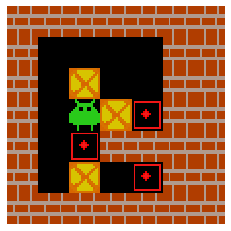

-2 do push right


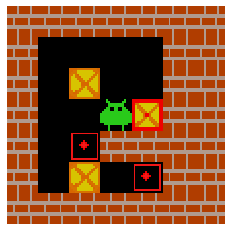

-3 do push left 


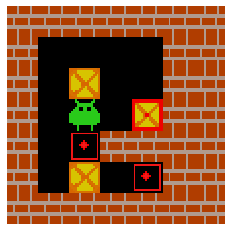

-4 do push left 


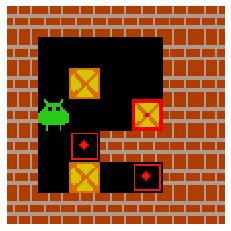

-5 do push down 


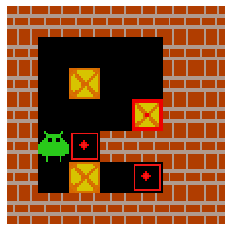

-6 do push down 


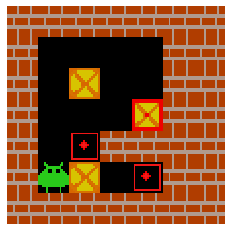

-7 do push right


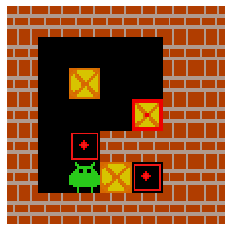

-8 do push right


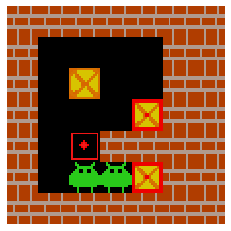

-9 do push left 


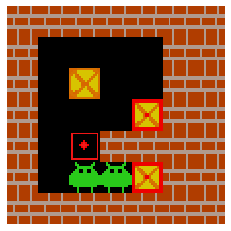

-10 do push left 


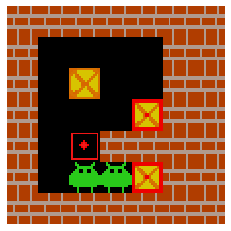

-11 do push up   


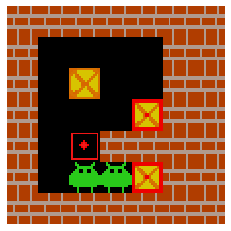

-12 do push up   


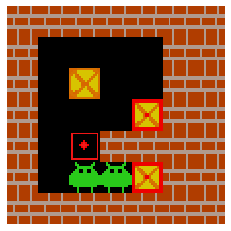

-13 do push up   


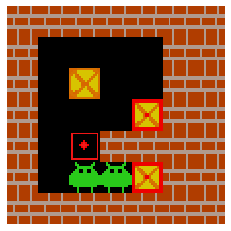

-14 do push up   


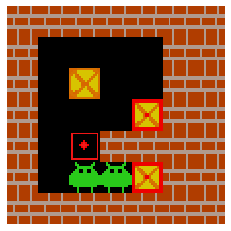

-15 do push right


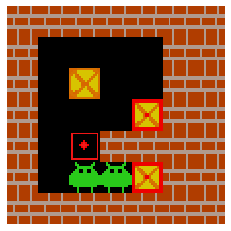

-16 do push down 


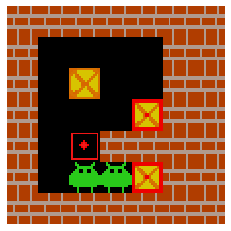

-17 do push down 


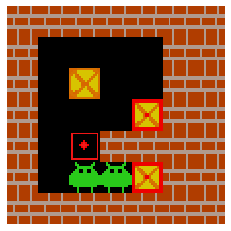

-18 do no operation


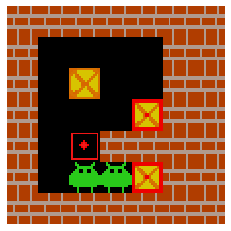

0.20000000000000015


In [7]:
import time

score = 0
ACTION_LOOKUP = env.unwrapped.get_action_lookup()
done = False

plt.imshow(env.render('rgb_array'))
for t in range(1, len(actions_solution) + 1):
    action = actions_solution[-t] + 1  # ignore 0 = no operation
    print(f'{-t} do {ACTION_LOOKUP[action]:10}')

    observation, reward, done, info = env.step(action)
    plt.imshow(observation)
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    score += reward
    
    if done:
        print('👌', "Episode finished after {} timesteps".format(t + 1))
        break

print(score)
env.close()

18
[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 1 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 4 0 0 0 0]
 [0 1 5 1 4 0 0]
 [0 0 0 0 0 0 0]]


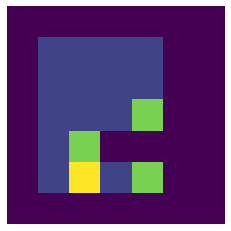

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 5 1 1 0 0]
 [0 1 3 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


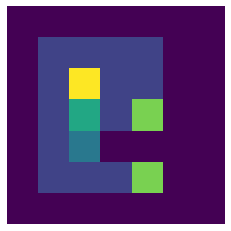

[[0 0 0 0 0 0 0]
 [0 1 5 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


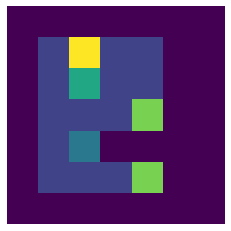

[[0 0 0 0 0 0 0]
 [0 5 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


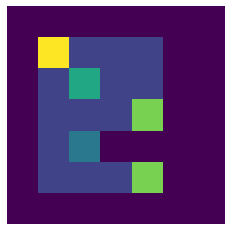

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 5 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


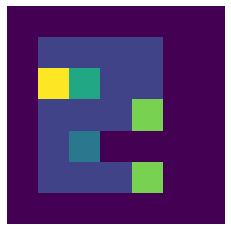

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 5 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


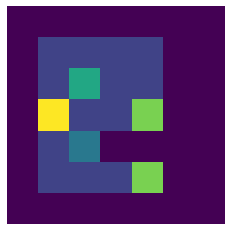

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 5 2 0 0 0 0]
 [0 1 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


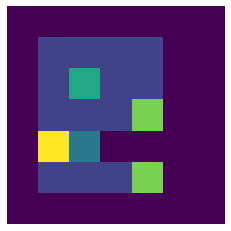

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 5 1 1 4 0 0]
 [0 0 0 0 0 0 0]]


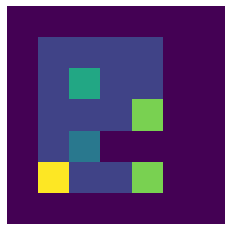

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 5 1 4 0 0]
 [0 0 0 0 0 0 0]]


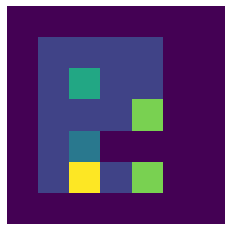

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 1 5 4 0 0]
 [0 0 0 0 0 0 0]]


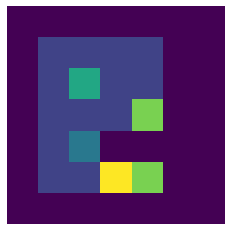

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 5 3 2 0 0]
 [0 0 0 0 0 0 0]]


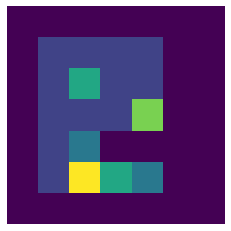

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 5 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


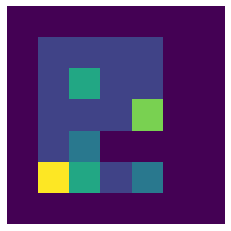

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 1 4 0 0]
 [0 5 2 0 0 0 0]
 [0 1 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


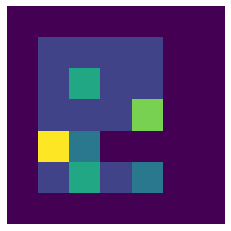

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 5 1 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


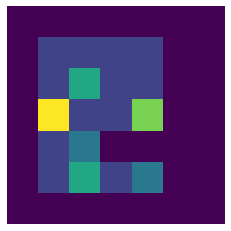

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 5 1 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


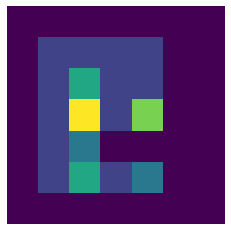

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 1 5 4 0 0]
 [0 1 2 0 0 0 0]
 [0 1 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


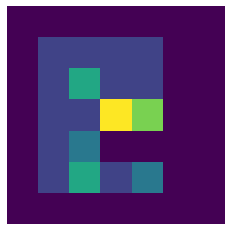

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 1 5 3 2 0 0]
 [0 1 2 0 0 0 0]
 [0 1 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


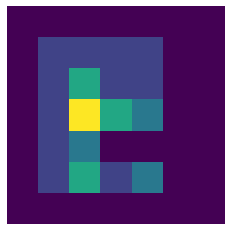

[[0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 1 3 1 1 0 0]
 [0 5 3 1 2 0 0]
 [0 1 2 0 0 0 0]
 [0 1 3 1 2 0 0]
 [0 0 0 0 0 0 0]]


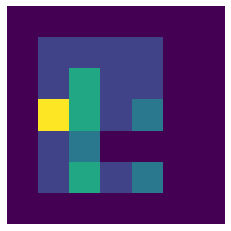

In [8]:
print(len(gen_data.best_old_room_states))

for best_old_room_state in gen_data.best_old_room_states:
    print(best_old_room_state)
    plt.imshow(best_old_room_state)
    plt.axis('off')
    plt.show()

## generate and augmentate data

In [9]:
def gen_states_distances(env, gen_data, num_boxes=3, max_action_length=20):
    actions_solution = genereate_game(env, gen_data, num_boxes, max_action_length, explored_states_max=5000)
    env.room_fixed[env.room_fixed == 5] = 1
    return gen_data.best_old_room_states[-1], env.room_fixed, [action + 1 for action in reversed(actions_solution[1:])]

### benchmark generation

In [10]:
# %%time
env = SokobanEnv(dim_room=(7, 7), num_boxes=3, num_gen_steps=None, reset=False)
gen_data = DataGenerator()

for _ in range(1):
    end_room_state_, end_room_fixed_, actions_solution_ = gen_states_distances(env, gen_data, num_boxes=2, max_action_length=15)
    print(end_room_state_)
    print()
    print(end_room_fixed_)
    print()
    print(actions_solution_)

print(len(actions_solution_))

[[0 0 0 0 0 0 0]
 [0 0 1 1 1 5 0]
 [0 2 1 1 3 2 0]
 [0 1 1 3 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]

[[0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0]
 [0 2 1 1 1 2 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]

[2, 3, 3, 3, 2, 4, 4, 2, 4, 1]
10


In [11]:
end_room_state_

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 5, 0],
       [0, 2, 1, 1, 3, 2, 0],
       [0, 1, 1, 3, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [12]:
end_room_state_[1:-1, 1:-1].shape

(5, 5)

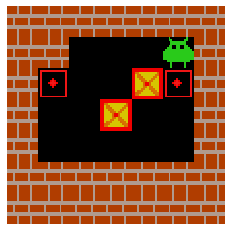

2 push down


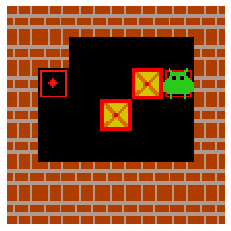

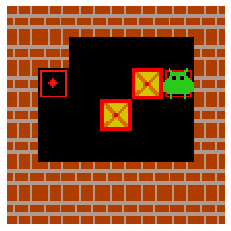

3 push left


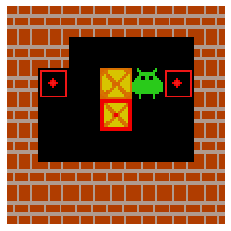

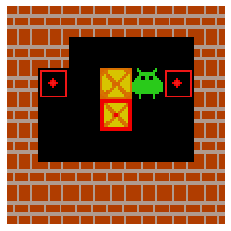

3 push left


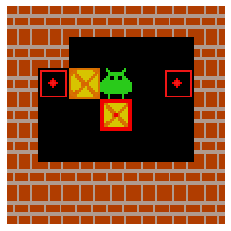

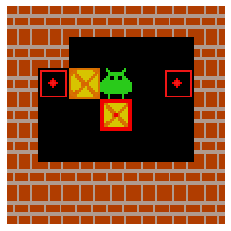

3 push left


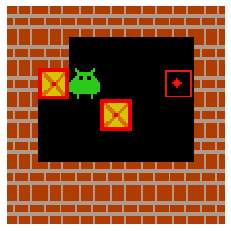

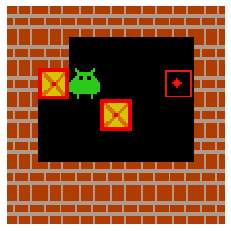

2 push down


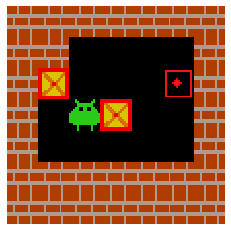

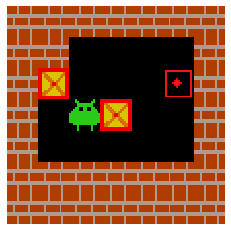

4 push right


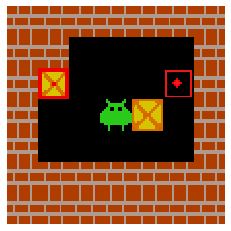

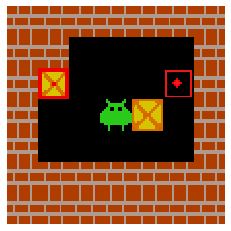

4 push right


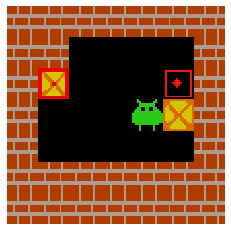

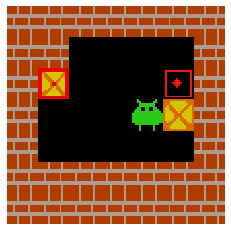

2 push down


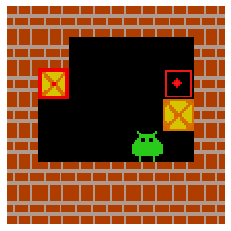

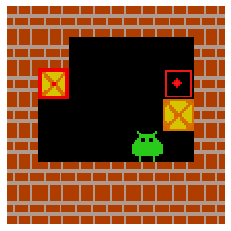

4 push right


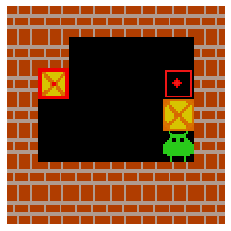

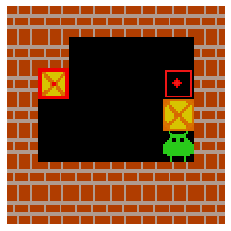

1 push up


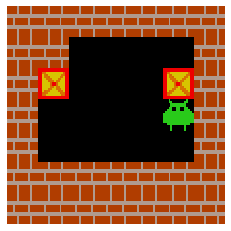

In [13]:
import gym
import gym_sokoban
from gym_sokoban.envs import ACTION_LOOKUP

player_env = SokobanEnv(dim_room=(7, 7), num_boxes=num_boxes, num_gen_steps=None, reset=False)
player_env.set_maxsteps(999999)
player_env.room_state, player_env.room_fixed, player_env.done = end_room_state_, end_room_fixed_, False
player_position = np.where(player_env.room_state == 5)
player_env.player_position = np.array([player_position[0][0], player_position[1][0]])
player_env.num_env_steps = 0

for action in actions_solution_:
    # plt.imshow(player_env.room_state)
    plt.imshow(player_env.render('rgb_array'))
    plt.axis('off')
    plt.show()
    
    print(action, ACTION_LOOKUP[action])
    
    _, _, done, _ = player_env.step(action)
    # plt.imshow(player_env.room_state) 
    plt.imshow(player_env.render('rgb_array'))
    plt.axis('off')
    plt.show()
    
    print()
    print()
    print()

In [14]:
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from multiprocessing import Process, Manager

class SokobanDataset(Dataset):
    def __init__(self, num_boxes=2, max_action_length=15):
        self.manager = Manager()
        
        self.num_boxes = num_boxes
        self.max_action_length = max_action_length
        
        self.env = SokobanEnv(dim_room=(7, 7), num_boxes=num_boxes, num_gen_steps=None, reset=False)
        self.gen_data = DataGenerator()
        
        self.data = self.manager.list()
        self.targets = self.manager.list()
        
        self.p1 = Process(target=self.generate_data)
        self.p1.start()
        self.p2 = Process(target=self.generate_data)
        self.p2.start()
        self.p3 = Process(target=self.generate_data)
        self.p3.start()
        self.p4 = Process(target=self.generate_data)
        self.p4.start()
        print("started backgound process")

        
    def generate_data(self):
        while True:
            if len(self.data) > 1500:
                time.sleep(0.01)
            else:
                end_room_state_, end_room_fixed_, actions_solution_ = gen_states_distances(env, gen_data, num_boxes=self.num_boxes, max_action_length=self.max_action_length)

                player_env = SokobanEnv(dim_room=(7, 7), num_boxes=num_boxes, num_gen_steps=None, reset=False)
                player_env.set_maxsteps(999999)
                player_env.room_state, player_env.room_fixed, player_env.done = end_room_state_, end_room_fixed_, False
                player_position = np.where(player_env.room_state == 5)
                player_env.player_position = np.array([player_position[0][0], player_position[1][0]])
                player_env.num_env_steps = 0

                for step_idx in range(len(actions_solution_)):
                    player_env_copy = deepcopy(player_env)
                    end_room_state_, end_room_fixed_ = player_env.room_state, player_env.room_fixed
                    for action in [1, 2, 3, 4]:                        
                        for rotation in range(4):
                            
                            while len(self.data) > 1500:
                                time.sleep(0.01)
                            
                            player_env_copy.room_state, player_env_copy.room_fixed = end_room_state_, end_room_fixed_
                            player_position = np.where(player_env_copy.room_state == 5)
                            player_env_copy.player_position = np.array([player_position[0][0], player_position[1][0]])
                            
                            player_env_copy.room_state = np.rot90(player_env_copy.room_state, rotation)
                            player_env_copy.room_fixed = np.rot90(player_env_copy.room_fixed, rotation)
                            player_position = np.where(player_env_copy.room_state == 5)
                            player_env_copy.player_position = np.array([player_position[0][0], player_position[1][0]])

                            # remove 0 "padding" from room_state
                            room_state_torch = torch.from_numpy((player_env_copy.room_state[1:-1, 1:-1]).astype(float)).flatten()
                            _, _, done, _ = player_env_copy.step(action)
                            target_room_state_torch = torch.from_numpy((player_env_copy.room_state[1:-1, 1:-1]).astype(float)).flatten()

                            action_torch = torch.from_numpy(np.asarray([action]).astype(float)).flatten()
                            self.data.append([torch.cat((room_state_torch, action_torch), 0), target_room_state_torch])
                            # self.targets.append(target_room_state_torch)
                    player_env.step(actions_solution_[step_idx])

    def __len__(self):
        return 100000

    def __getitem__(self, idx):
        while len(self.data) < 64:
            time.sleep(0.01)
            
        data = self.data.pop()
        return data[0], data[1]

In [15]:
class SokobanDatasetTest(Dataset):
    def __init__(self, num_boxes=2, max_action_length=15):
        self.num_boxes = num_boxes
        self.max_action_length = max_action_length
        
        self.env = SokobanEnv(dim_room=(7, 7), num_boxes=num_boxes, num_gen_steps=None, reset=False)
        self.gen_data = DataGenerator()
        
        self.data = []
        self.targets = []
        
        for _ in range(150):
            end_room_state_, end_room_fixed_, actions_solution_ = gen_states_distances(env, gen_data, num_boxes=self.num_boxes, max_action_length=self.max_action_length)
            
            player_env = SokobanEnv(dim_room=(7, 7), num_boxes=num_boxes, num_gen_steps=None, reset=False)
            player_env.set_maxsteps(999999)
            player_env.room_state, player_env.room_fixed, player_env.done = end_room_state_, end_room_fixed_, False
            player_position = np.where(player_env.room_state == 5)
            player_env.player_position = np.array([player_position[0][0], player_position[1][0]])
            player_env.num_env_steps = 0
            
            for step_idx in range(len(actions_solution_)):
                for action in [1, 2, 3, 4]:
                    for rotation in range(4):
                        player_env_copy = deepcopy(player_env)
                        
                        player_env_copy.room_state = np.rot90(player_env_copy.room_state, rotation)
                        player_env_copy.room_fixed = np.rot90(player_env_copy.room_fixed, rotation)
                        player_position = np.where(player_env_copy.room_state == 5)
                        player_env_copy.player_position = np.array([player_position[0][0], player_position[1][0]])
                        
                        room_state_torch = torch.from_numpy((player_env_copy.room_state[1:-1, 1:-1]).astype(float)).flatten()
                        _, _, done, _ = player_env_copy.step(action)
                        target_room_state_torch = torch.from_numpy((player_env_copy.room_state[1:-1, 1:-1]).astype(float)).flatten()

                        action_torch = torch.from_numpy(np.asarray([action]).astype(float)).flatten()
                        self.data.append([torch.cat((room_state_torch, action_torch), 0), target_room_state_torch])
                        # self.targets.append(target_room_state_torch)
                player_env.step(actions_solution_[step_idx])
                
        print("len(SokobanDatasetTest) =", len(self.data))
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        return data[0], data[1]

In [16]:
import torch
from torch import nn, optim

def create_model():
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            self.model = nn.Sequential(
                nn.Linear(5*5+1, 512),
                nn.PReLU(),
                #nn.Dropout(0.1),
                
                nn.Linear(512, 1024),
                nn.PReLU(),
                #nn.Dropout(0.1),
                
                nn.Linear(1024, 2048),
                nn.PReLU(),
                #nn.Dropout(0.1),
                
                nn.Linear(2048, 5012),
                nn.PReLU(),
                #nn.Dropout(0.1),
                
                nn.Linear(5012, 2048),
                nn.PReLU(),
                #nn.Dropout(0.1),
                
                nn.Linear(2048, 1024),
                nn.PReLU(),
                #nn.Dropout(0.1),
                
                nn.Linear(1024, 512),
                nn.PReLU(),                
                #nn.Dropout(0.1),

                nn.Linear(512, 5*5)
            )

        def forward(self, x):
            return self.model(x)

    return Net()


In [17]:
from torchsummary import summary

summary(create_model(), (5*5+1,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          13,824
             PReLU-2                  [-1, 512]               1
            Linear-3                 [-1, 1024]         525,312
             PReLU-4                 [-1, 1024]               1
            Linear-5                 [-1, 2048]       2,099,200
             PReLU-6                 [-1, 2048]               1
            Linear-7                 [-1, 5012]      10,269,588
             PReLU-8                 [-1, 5012]               1
            Linear-9                 [-1, 2048]      10,266,624
            PReLU-10                 [-1, 2048]               1
           Linear-11                 [-1, 1024]       2,098,176
            PReLU-12                 [-1, 1024]               1
           Linear-13                  [-1, 512]         524,800
            PReLU-14                  [

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = create_model().to(device)

In [20]:
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [21]:
hold_train_loss = []
hold_test_loss = []

In [22]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048 * 2, rlimit[1]))

In [23]:
data_loader_test = DataLoader(SokobanDatasetTest(num_boxes=3, max_action_length=18), batch_size=1)

len(SokobanDatasetTest) = 32336


In [24]:
data_loader_train = DataLoader(SokobanDataset(num_boxes=3, max_action_length=18), batch_size=64)

started backgound process


Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/pascal/miniconda3/envs/AML/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/pascal/miniconda3/envs/AML/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pascal/miniconda3/envs/AML/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-14-86a0ebdd386d>", line 50, in generate_data
    time.sleep(0.01)
  File "/home/pascal/miniconda3/envs/AML/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-14-86a0ebdd386d>", line 50, in generate_data
    time.sleep(0.01)
KeyboardInterrupt
KeyboardInterrupt
Process Process-5:
Traceback (most recent call last):
  File "/home/pascal/miniconda3/envs/AML/lib/python3.7/multiprocessing/process.py", li

In [25]:
best_loss = 0

Epoch:   3%|▎         | 250/9999 [13:56:39<537:33:04, 198.50s/it]

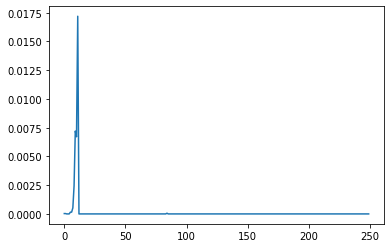

0.0

tensor([[0., 1., 1., 5., 3., 1., 1., 1., 3., 1., 1., 3., 1., 0., 0., 1., 0., 1.,
         0., 0., 1., 1., 0., 0., 0.]], device='cuda:0')
tensor([[1.0631, 1.4714, 1.5561, 1.4377, 0.9886, 1.4308, 1.8947, 2.0138, 1.9263,
         1.3870, 1.5025, 1.8570, 2.2007, 1.9794, 1.6054, 1.3822, 1.9261, 2.2398,
         1.7989, 1.4044, 1.0487, 1.4618, 1.6517, 1.5519, 1.0866]],
       device='cuda:0')
2.898077 1.7120119


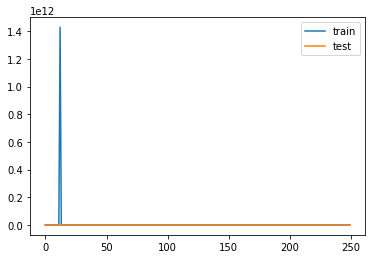

KeyboardInterrupt: 

In [26]:
from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm
from IPython.display import clear_output

epochs = 9999

mean_equal_res_test_list = []

fx, tr_y = None, None
pbar = tqdm(total=epochs, desc='Epoch')
for epoch in range(epochs):
    model.train()
    train_loss = []
    test_loss = []
    for batch_idx, (data, target) in tqdm_notebook(enumerate(data_loader_train), total=len(data_loader_train), desc='Batch', leave=False):
        tr_x, tr_y = data.float().to(device), target.float().to(device)

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        fx = model(tr_x)
        output = loss(fx, tr_y.view(-1, 5*5))  # loss for this batch
        train_loss.append( output.detach().cpu().numpy())

        # Backward
        output.backward()

        # Update parameters based on backprop
        optimizer.step()
        
    printer = []
    equal_res_test = []
    with torch.no_grad():
        model.eval()
        for batch_idx, (data, target) in enumerate(data_loader_test):
            tr_x, tr_y = data.float().to(device), target.float().to(device)
            fx = model(tr_x)
            test_loss.append(loss(fx, tr_y.view(-1, 5*5)).detach().cpu().numpy())  # loss for this batch
            printer = [tr_y, fx]
            
            room_state_next = fx.round().abs().int().detach().cpu().numpy()
            room_state_next = np.clip(room_state_next, 0, 5)
        
            equal_res_test.append(np.array_equal(room_state_next, tr_y.int().detach().cpu().numpy()))

    equal_res_test = np.asarray(equal_res_test)

    hold_train_loss.append(np.mean(train_loss))
    hold_test_loss.append(np.mean(test_loss))
    
    clear_output(True)
    pbar.update(1)
    # plt.plot(hold_train_loss.mean(), label='train')
    mean_equal_res_test = equal_res_test.mean()
    mean_equal_res_test_list.append(mean_equal_res_test)
    plt.plot(mean_equal_res_test_list, label='test')
    # plt.legend()
    plt.show()
    
    print(mean_equal_res_test)
    print()
    print(printer[0])
    print(printer[1])
    
    if mean_equal_res_test > best_loss:
        best_loss = mean_equal_res_test
        torch.save(model.state_dict(), f"env_model/env_model_{epoch}_{best_loss}.pth")
    
    print(hold_train_loss[-1], hold_test_loss[-1])
    
    plt.plot(hold_train_loss, label='train')
    plt.plot(hold_test_loss, label='test')
    plt.legend()
    plt.show()

In [27]:
pbar.close()

In [30]:
max(mean_equal_res_test_list)

0.017194458189015337

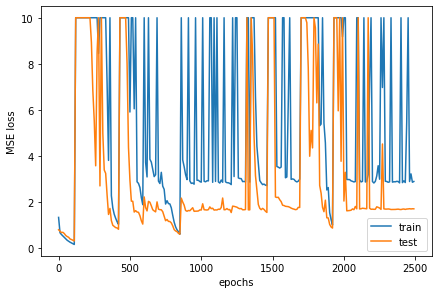

In [37]:
x = [value * 10 for value in range(len(hold_train_loss))]
plt.plot(x, [min(value, 10) for value in hold_train_loss], label='train')
plt.plot(x, [min(value, 10) for value in hold_test_loss], label='test')
plt.legend()
plt.tight_layout()
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.savefig("own_model_loss.pdf")
plt.show()

In [ ]:
torch.save(model.state_dict(), "DAVI_steps_10_longTraining_no_batchnorm.pth")

In [ ]:
plt.plot(np.array([min(x, 4) for x in hold_train_loss[:725]]), label='train')
plt.plot(np.array(hold_test_loss[:725]), label='test')
plt.ylim([-0.1, 4.35])
plt.legend()

plt.savefig("longTraining_no_batchnorm/DAVI_steps_10_loss_longTraining_no_batchnorm_lim.svg")
plt.savefig("longTraining_no_batchnorm/DAVI_steps_10_loss_longTraining_no_batchnorm_lim.pdf")
plt.show()

In [ ]:
from tqdm import tnrange, tqdm_notebook
from IPython.display import clear_output

epochs = 9999


model.train()

fx, tr_y = None, None
for epoch in tnrange(epochs, desc='Epoch'):
    train_loss = []
    test_loss = []
    for batch_idx, (data, target) in tqdm_notebook(enumerate(data_loader_train), total=len(data_loader_train), desc='Batch', leave=False):
        tr_x, tr_y = data.float().to(device), target.float().to(device)

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        fx = model(tr_x)
        output = loss(fx, tr_y.view(-1, 1))  # loss for this batch
        train_loss.append( output.detach().cpu().numpy())

        # Backward
        output.backward()

        # Update parameters based on backprop
        optimizer.step()
        
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader_test):
            tr_x, tr_y = data.float().to(device), target.float().to(device)
            fx = model(tr_x)
            test_loss.append(loss(fx, tr_y.view(-1, 1)).detach().cpu().numpy())  # loss for this batch

    hold_train_loss.append(np.mean(train_loss))
    hold_test_loss.append(np.mean(test_loss))
    
    clear_output(True)
    plt.plot(np.array(hold_train_loss), label='train')
    plt.plot(np.array(hold_test_loss), label='test')
    plt.legend()
    plt.show()
    
    print(hold_train_loss[-1], hold_test_loss[-1])

In [ ]:
x = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(DataLoader(SokobanDatasetTest(max_action_length=10), batch_size=64)):
        tr_x, tr_y = data.float().to(device), target.float().to(device)
        fx = model(tr_x)
        x.append(loss(fx, tr_y.view(-1, 1)).detach().cpu().numpy())  # loss for this batch
        
print(np.mean(x))

In [ ]:
model = create_model().to(device)
model.load_state_dict(torch.load("DAVI_steps_10_longTraining.pth"))

In [ ]:
x = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(DataLoader(SokobanDatasetTest(max_action_length=10), batch_size=64)):
        tr_x, tr_y = data.float().to(device), target.float().to(device)
        fx = model(tr_x)
        x.append(loss(fx, tr_y.view(-1, 1)).detach().cpu().numpy())  # loss for this batch
        
print(np.mean(x))

In [ ]:
data_loader_train = DataLoader(SokobanDataset(max_action_length=13), batch_size=64)
data_loader_test = DataLoader(SokobanDatasetTest(max_action_length=13), batch_size=64)

In [ ]:
from tqdm import tnrange, tqdm_notebook
from IPython.display import clear_output

epochs = 9999


model.train()

fx, tr_y = None, None
for epoch in tnrange(epochs, desc='Epoch'):
    train_loss = []
    test_loss = []
    for batch_idx, (data, target) in tqdm_notebook(enumerate(data_loader_train), total=len(data_loader_train), desc='Batch', leave=False):
        tr_x, tr_y = data.float().to(device), target.float().to(device)

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        fx = model(tr_x)
        output = loss(fx, tr_y.view(-1, 1))  # loss for this batch
        train_loss.append( output.detach().cpu().numpy())

        # Backward
        output.backward()

        # Update parameters based on backprop
        optimizer.step()
        
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader_test):
            tr_x, tr_y = data.float().to(device), target.float().to(device)
            fx = model(tr_x)
            test_loss.append(loss(fx, tr_y.view(-1, 1)).detach().cpu().numpy())  # loss for this batch

    hold_train_loss.append(np.mean(train_loss))
    hold_test_loss.append(np.mean(test_loss))
    
    clear_output(True)
    plt.plot(np.array(hold_train_loss), label='train')
    plt.plot(np.array(hold_test_loss), label='test')
    plt.legend()
    plt.show()
    
    print(hold_train_loss[-1], hold_test_loss[-1])